Importing Libraries

In [22]:
from pydriller import Repository
import csv
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("diff_extraction.csv")

total_commits = df['Hash'].nunique()
total_files = df['Filename'].nunique()
print(f"Total commits: {total_commits}")
print(f"Total files: {total_files}")

files_per_commit = df.groupby('Hash')['Filename'].nunique()
avg_files_per_commit = files_per_commit.mean()
print(f"Average number of modified files per commit: {avg_files_per_commit:.2f}")

fix_type_counts = df['LLM Inference (fix type)'].value_counts()
print("")
print("Distribution of fix types (LLM Inference):")
print(fix_type_counts)

def get_extension(filename):
    if pd.notna(filename):
        return str(filename).split('.')[-1]
    else:
        return ''

df['Extension'] = df['Filename'].apply(get_extension)
extension_counts = df['Extension'].value_counts()
print("")
print("Most frequently modified file extensions:")
print(extension_counts)

Total commits: 141
Total files: 28
Average number of modified files per commit: 1.21

Distribution of fix types (LLM Inference):
LLM Inference (fix type)
add missing import                     6
add missing newline                    5
add missing line                       3
update backend_option.py               2
add test for memory_usage              2
                                      ..
add missing link to mprof script       1
add mprof example                      1
add plot_action to plot_file           1
add more comments to the docstrings    1
add missing docs to profiled.js        1
Name: count, Length: 153, dtype: int64

Most frequently modified file extensions:
Extension
py          130
rst          17
mprof        15
Makefile      2
yml           2
MANIFEST      1
xml           1
              1
mplot         1
maction       1
bat           1
Name: count, dtype: int64


In [ ]:
from radon.metrics import mi_visit
from radon.complexity import cc_visit

df = pd.read_csv("diff_extraction.csv")

mi_bef_list, mi_aft_list = [], []
cc_bef_list, cc_aft_list = [], []
loc_bef_list, loc_aft_list = [], []

for idx, row in df.iterrows():
    code_bef = row['Source Code (before)']
    code_aft = row['Source Code (current)']
    
    if pd.isna(code_bef): 
        code_bef = ''
    if pd.isna(code_aft): 
        code_aft = ''
    
    try:
        mi_bef = mi_visit(code_bef, True)
    except:
        mi_bef = None
    try:
        mi_aft = mi_visit(code_aft, True)
    except:
        mi_aft = None
    
    try:
        cc_bef = 0
        if code_bef:
            for func in cc_visit(code_bef):
                cc_bef += func.complexity
    except:
        cc_before = None
    try:
        cc_aft = 0
        if code_aft:
            for func in cc_visit(code_aft):
                cc_aft += func.complexity
    except:
        cc_after = None
    
    loc_bef = len(code_bef.splitlines())
    loc_aft = len(code_aft.splitlines())
    
    mi_bef_list.append(mi_bef)
    mi_aft_list.append(mi_aft)
    cc_bef_list.append(cc_bef)
    cc_aft_list.append(cc_aft)
    loc_bef_list.append(loc_bef)
    loc_aft_list.append(loc_aft)

df['MI_Before'] = mi_bef_list
df['MI_After'] = mi_aft_list
df['CC_Before'] = cc_bef_list
df['CC_After'] = cc_aft_list
df['LOC_Before'] = loc_bef_list
df['LOC_After'] = loc_aft_list

df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']

df.head()

,Hash,Message,Filename,Source Code (before),Source Code (current),Diff,LLM Inference (fix type),Rectified Message,MI_Before,MI_After,CC_Before,CC_After,LOC_Before,LOC_After,MI_Change,CC_Change,LOC_Change
0,8800fe9252802753643a0e48de52c9d8d12f52f6,Port to OSX and other fixes,examples/plot_memory.py,"""""""\nPlot memory usage of a numeric computatio...","""""""\nPlot memory usage of a numeric computatio...","@@ -1,38 +1,18 @@\n """"""\n Plot memory usage of...",add memory usage plot,add memory usage plot,76.246473,97.400162,0,0,38,18,21.153689,0,-20
1,8800fe9252802753643a0e48de52c9d8d12f52f6,Port to OSX and other fixes,memory_profiler.py,"""""""Get process information""""""\n\n__version__ =...","""""""Get process information""""""\n\n__version__ =...","@@ -6,17 +6,18 @@ _CMD_USAGE = ""python -m memo...",add docs for memory_usage,add docs for memory_usage,NaN,NaN,0,0,244,246,NaN,0,2
2,c953ca4a9df3a3321166803752608b70e2f2632a,FIX: display last statement,memory_profiler.py,"""""""Get process information""""""\n\n__version__ =...","""""""Get process information""""""\n\n__version__ =...","@@ -224,7 +224,7 @@ def show_results(prof, str...",show memory usage in profiling results,show memory usage in profiling results,51.474161,51.563708,46,46,257,257,0.089547,0,0
3,ec9ee7032b01cf9350628a57f9c5111a48093366,Fix typos in README and make a new release,README.rst,Memory Profiler\n---------------\nThis is a py...,Memory Profiler\n---------------\nThis is a py...,"@@ -9,7 +9,7 @@ Installation\n ------------\n ...",add missing documentation,add missing documentation,NaN,NaN,0,0,66,66,NaN,0,0
4,ec9ee7032b01cf9350628a57f9c5111a48093366,Fix typos in README and make a new release,memory_profiler.py,"""""""Get process information""""""\n\n__version__ =...","""""""Get process information""""""\n\n__version__ =...","@@ -1,6 +1,6 @@\n """"""Get process information""""...",add missing line,add missing line,51.563708,51.563708,46,46,257,257,0.000000,0,0


Setting Up CodeBERT

In [3]:
import torch
from transformers import RobertaTokenizer, RobertaModel

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.eval()

/Users/arinmehta/Documents/GitHub/STT/Assignment-1/pydriller_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [4]:
df = pd.read_csv("diff_extraction.csv")

def compute_semantic_similarity(code1, code2):
    if not code1 or not code2:
        return None

    code1 = str(code1)
    code2 = str(code2)
        
    inputs1 = tokenizer(code1, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs2 = tokenizer(code2, return_tensors='pt', padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        emb1 = model(**inputs1).last_hidden_state.mean(dim=1)
        emb2 = model(**inputs2).last_hidden_state.mean(dim=1)

    if torch.norm(emb1) == 0 or torch.norm(emb2) == 0:
        return 0.0

    return float(torch.nn.functional.cosine_similarity(emb1, emb2, dim=1))

bef_codes = df["Source Code (before)"]
aft_codes = df["Source Code (current)"]

df["Semantic_Similarity"] = [
    compute_semantic_similarity(bef, aft) for bef, aft in zip(bef_codes, aft_codes)
]

df.to_csv("diff_extraction.csv", index=False)

df["Semantic_Similarity"].head(10)

0    0.961138
1    0.999291
2    1.000000
3    0.999989
4    0.999998
5    0.804435
6    0.999998
7    0.999907
8    1.000000
9    0.999759
Name: Semantic_Similarity, dtype: float64

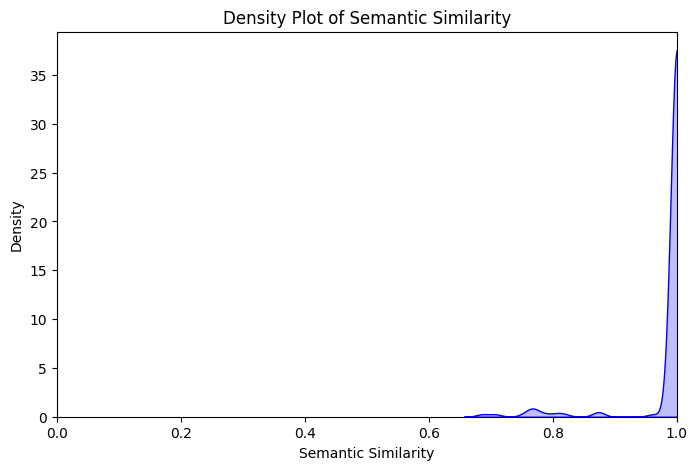

In [23]:
plt.figure(figsize=(8,5))
sns.kdeplot(df['Semantic_Similarity'].dropna(), 
            fill=True, 
            color='blue', 
            bw_adjust=0.5)
plt.title('Density Plot of Semantic Similarity')
plt.xlabel('Semantic Similarity')
plt.ylabel('Density')
plt.xlim(0,1)
plt.show()

Setting Up BLEU

In [6]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /Users/arinmehta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/arinmehta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
def compute_token_similarity(code1,code2):
    if not code1 or not code2:
        return None
    
    input1 = str(code1)
    input2 = str(code2)

    ref_tokens = nltk.word_tokenize(input1)
    hyp_tokens = nltk.word_tokenize(input2)

    if not ref_tokens or not hyp_tokens:
        return 0.0
    
    smooth = SmoothingFunction().method4
    score = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smooth)
    return float(score)

bef_codes = df["Source Code (before)"]
aft_codes = df["Source Code (current)"]

df["Token_Similarity"] = [
    compute_token_similarity(bef, aft) for bef, aft in zip(bef_codes, aft_codes)
]

df.to_csv("diff_extraction.csv", index=False)

df["Token_Similarity"].head(10)


0    0.104053
1    0.943228
2    0.997634
3    0.975265
4    0.998307
5    0.000000
6    0.998348
7    0.992705
8    0.952307
9    0.990441
Name: Token_Similarity, dtype: float64

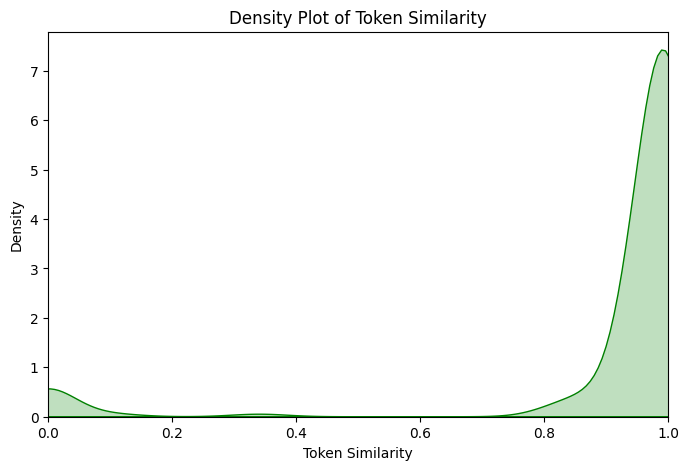

In [24]:
plt.figure(figsize=(8,5))
sns.kdeplot(df['Token_Similarity'].dropna(), 
            fill=True, 
            color='green', 
            bw_adjust=0.5)
plt.title('Density Plot of Token Similarity')
plt.xlabel('Token Similarity')
plt.ylabel('Density')
plt.xlim(0,1)
plt.show()

In [9]:
df = pd.read_csv("diff_extraction.csv")

def classify(val, threshold):
    if pd.isna(val):
        return 'Major'
    if val>=threshold:
        return 'Minor'
    else:
        return 'Major'

s_threshold = 0.8
t_threshold = 0.75

semantic_class = []
token_class = []

for semantic_sim, token_sim in zip(df['Semantic_Similarity'], df['Token_Similarity']):
    sem_class = classify(semantic_sim, s_threshold)
    tok_class = classify(token_sim,t_threshold)

    semantic_class.append(sem_class)
    token_class.append(tok_class)

df['Semantic_class'] = semantic_class
df['Token_class'] = token_class

df.to_csv("diff_extraction.csv", index=False)

df[['Semantic_class', 'Token_class']].head(10)


,Semantic_class,Token_class
0,Minor,Major
1,Minor,Minor
2,Minor,Minor
3,Minor,Minor
4,Minor,Minor
5,Minor,Major
6,Minor,Minor
7,Minor,Minor
8,Minor,Minor
9,Minor,Minor


In [ ]:
classes_agree = []

for sem_class, tok_class in zip(df['Semantic_class'], df['Token_class']):
    if sem_class == tok_class:
        agree = 'YES'
    else:
        agree = 'NO'
    classes_agree.append(agree)

df.to_csv("diff_extraction.csv", index=False)
df['Classes_Agree'] = classes_agree

In [13]:
df['Classes_Agree'].head(10)

0     NO
1    YES
2    YES
3    YES
4    YES
5     NO
6    YES
7    YES
8    YES
9    YES
Name: Classes_Agree, dtype: object

In [15]:
agree_counts = df['Classes_Agree'].value_counts()
print(agree_counts)

Classes_Agree
YES    166
NO       6
Name: count, dtype: int64


In [16]:
agree_percent = df['Classes_Agree'].value_counts(normalize=True) * 100
print(agree_percent)

Classes_Agree
YES    96.511628
NO      3.488372
Name: proportion, dtype: float64
